# MOLT Solver Tutorial

This notebook is intended to serve as a tool to demonstrate the coding process for the Method-of-Lines-Transpose (MOLT). Additionally, our document is designed to be entirely self-contained with detailed explanations, supplemented with relevant snippets from publications.  

## Nonlinear Degenerate Advection-Diffusion Equations

In MOLT-based schemes, the spatial derivatives are represented as expansions in integral operators, dubbed *successive convolution*. We demonstrate with a discretization of the following nonlinear, possibly degenerate, parabolic equation

\begin{equation}
    u_{t}+f(u)_{x}=g(u)_{xx},\quad x\in[a,b],
\end{equation}

where $g'(u)\geq0$ and $g'(u)$ can vanish for some values of $u$.

### Import Packages

In [1]:
# Computing
import numpy as np
from numba import jit
from pylab import meshgrid

# Profiling 
import time
import cProfile
import pstats
import io

# Plotting Utilities
import matplotlib.pyplot as plt
from IPython import display
import ipywidgets as widgets
from ipywidgets import interactive
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

## 2. Representation of differential operators
### 2.1. Approximation of the second order derivative $\partial_{xx}$

We consider the differential operator

\begin{equation}
    \mathcal{L}_{0} = \mathcal{I} - \frac{1}{ \alpha^{2} } \partial_{xx}.
\end{equation}

Suppose that $w(x)$ is a solution to the following differential equation

\begin{equation}
    \mathcal{L}_{0}[w,\alpha](x) = v(x).
\end{equation}

We can invert this differential operator analytically to obtain the solution

\begin{equation}
    \mathcal{L}_{0}^{-1} [v,\alpha](x) = \mathcal{I}_{0}[v,\alpha](x) + A_{0} e^{-\alpha(x-a)} + B_{0} e^{-\alpha(b-x)},  
\end{equation}

where

\begin{equation}
    \mathcal{I}_{0}[v,\alpha](x) = \frac{ \alpha }{2} \int_{a}^{b} e^{-\alpha \lvert x-y \rvert } v(y) \,dy.
\end{equation}

For periodic boundary conditions,

\begin{align}
    A_{0} = \frac{ I^{0} [v,\alpha](b) }{1 - \mu} \quad \text{ and } \quad 
    B_{0} = \frac{ I^{0} [v,\alpha](a) }{1 - \mu}
\end{align}

where $\mu = e^{-\alpha (b-a)}$. As in the approximation of $\partial_x$, we can define the related operator

\begin{equation}
    \mathcal{D}_0 = \mathcal{I} - \mathcal{L}_{0}^{-1}
\end{equation}

and write a series expansion for it. If we solve this equation for $\mathcal{L}_{0}^{-1}$, we obtain

\begin{equation}
    \mathcal{L}_0 = \left( \mathcal{I} - \mathcal{D}_{0} \right)^{-1}.
\end{equation}

Then, proceeding as before, we can say

\begin{equation}
    \frac{1}{ \alpha^{2} } \partial_{xx} = \mathcal{I} - \mathcal{L}_0 = \mathcal{L}_0 \left( \mathcal{L}_{0}^{-1} - \mathcal{I} \right) = - \frac{ \mathcal{D}_0 }{ \mathcal{I} - \mathcal{D}_{0} } = - \sum_{p=1}^{\infty} \mathcal{D}_{0}^{p} \iff \partial_{xx} = -\alpha^{2} \sum_{p=1}^{\infty} \mathcal{D}_{0}^{p}.
\end{equation}

Here this convolution operator can be defined *succesively* as

\begin{equation}
    \mathcal{D}_{0}^{p} = \mathcal{D}_{0} \left[ \mathcal{D}_{0}^{p-1} \right].
\end{equation}



### 2.2. Approximation of the first order derivative $\partial_x$

In approximating the first derivative, we need to consider the direction of the wave characteristics to ensure stability. We introduce the operators $\mathcal{L}_L$ and $\mathcal{L}_R$ defined by

\begin{align}
    \mathcal{L}_L = \mathcal{I} + \frac{1}{\alpha}\partial_x \quad \text{and} \quad
    \mathcal{L}_R = \mathcal{I} - \frac{1}{\alpha}\partial_x,
\end{align}

where $x \in [a,b]$ and $\alpha > 0$ is a constant. Additionally, we have the related operators defined from the $\mathcal{L}$'s

\begin{align}
    \mathcal{D}_L = \mathcal{I} - \mathcal{L}_{L}^{-1} \quad \text{and} \quad
    \mathcal{D}_R = \mathcal{I} - \mathcal{L}_{R}^{-1}.
\end{align}

Our goal is to determine an expansion in terms of the $\mathcal{D}$'s using the integrals formed from the respective inversions of $\mathcal{L}_L$ and $\mathcal{L}_R$. We describe this procedure below.



Consider the case with $\mathcal{L}_L$ and $\mathcal{D}_L$ first. Suppose that $w(x)$ is a solution to the differential equation

\begin{equation}
    \mathcal{L}_L [w,\alpha](x) = v(x).
\end{equation}

Then, we can analytically invert $\mathcal{L}_L$ so that

\begin{equation}
    \mathcal{L}_{L}^{-1} [v,\alpha](x) = I^{L} [v,\alpha](x) + A_{L} e^{-\alpha (x-a)},
\end{equation}

where $A_{L}$ is a constant determined via the boundary conditions and

\begin{equation}
    I^{L} [v,\alpha](x) = \alpha \int_{a}^{x}e^{-\alpha (x-y)} v(y) \,dy. 
\end{equation}

Since we are prescribing periodic boundary conditions, we find that

\begin{equation}
    A_{L} = \frac{ I^{L} [v,\alpha](b) }{1 - \mu},
\end{equation}

where

\begin{equation}
    \mu = e^{-\alpha (b-a)}.
\end{equation}

Similarly, for $\mathcal{L}_R$ and $\mathcal{D}_R$, we find that

\begin{equation}
    \mathcal{L}_{R}^{-1} [v,\alpha](x) = I^{R} [v,\alpha](x) + B_{R} e^{-\alpha (b-x)},
\end{equation}

where $B_{R}$ is a constant determined via the boundary conditions and

\begin{equation}
    I^{R} [v,\alpha](x) = \alpha \int_{x}^{b}e^{-\alpha (x-y)} v(y) \,dy. 
\end{equation}


We are now in place to write $\frac{1}{\alpha} \partial_x $ as a series expansion in $\mathcal{D}_{L}$ and $\mathcal{D}_{R}$. To do this, we can write

\begin{equation}
    \frac{1}{\alpha} \partial_x = \mathcal{L}_L - \mathcal{I} = \mathcal{L}_L \left( \mathcal{I} - \mathcal{L}_{L}^{-1} \right) = \frac{ \mathcal{D}_{L} }{ \mathcal{I} - \mathcal{D}_{L}} = \sum_{p=1}^{\infty} \mathcal{D}_{L}^{p} \iff \partial_x = \alpha \sum_{p=1}^{\infty} \mathcal{D}_{L}^{p}.
\end{equation}

Likewise, for the data that propogrates from the right end of the domain, we have that

\begin{equation}
    \frac{1}{\alpha} \partial_x = \mathcal{I} - \mathcal{L}_R = \mathcal{L}_R \left( \mathcal{L}_{R}^{-1} - \mathcal{I} \right) = -\frac{ \mathcal{D}_{R} }{ \mathcal{I} - \mathcal{D}_{R}} = -\sum_{p=1}^{\infty} \mathcal{D}_{R}^{p} \iff \partial_x = -\alpha \sum_{p=1}^{\infty} \mathcal{D}_{R}^{p} .
\end{equation}

We also note the following recursive operations for these operators

\begin{align}
    \mathcal{D}_{L}^{p} &= \mathcal{D}_{L} \left[ \mathcal{D}_{L}^{p-1} \right] \quad \text{and} \quad
    \mathcal{D}_{R}^{p} &= \mathcal{D}_{R} \left[ \mathcal{D}_{R}^{p-1} \right].
\end{align}

Thus, higher order convolution operators are *succesively* defined in terms of lower order operators. 

In truncating the expansions for approximating the first derivatives, we determine how each term effects the error. From our paper, it was shown for periodic boundary conditions that the $k$-th partial sum yields a method that is accurate to order $k$ in time. 



## 3. Approximation of partial sums
In summary,  $-f(u)_{x}+g(u)_{xx}$ can be represented as a linear combination of three infinite series:

\begin{align*}
	-\alpha_{L}\sum_{p=1}^{\infty}\mathcal{D}_{L}^{p}[f^{+}(u),\alpha_{L}]
	+\alpha_{R}\sum_{p=1}^{\infty}\mathcal{D}_{R}^{p}[f^{-}(u),\alpha_{R}]
	-\alpha_{0}^2 \sum_{p=1}^{\infty} \mathcal{D}^{p}_{0}[g(u),\alpha_{0}].
\end{align*}

In numerical simulations, we have to truncate the series and only compute the corresponding partial sum.  In particular, the above equation is approximated by the $k^{th}$ partial sum

\begin{align*}
-f(u)_{x}+g(u)_{xx}\approx-\alpha_{L}\sum_{p=1}^{k}\mathcal{D}_{L}^{p}[f^{+}(u),\alpha_{L}]
+\alpha_{R}\sum_{p=1}^{k}\mathcal{D}_{R}^{p}[f^{-}(u),\alpha_{R}]
-\alpha_{0}^2 \sum_{p=1}^{k} \mathcal{D}^{p}_{0}[g(u),\alpha_{0}].
\end{align*}

### Computing the Inverse Operators: Periodic boundary conditions

For the case of periodic boundary conditions, we will require

\begin{align*}
    \mathcal{D}_{L}^{k}(a) &= \mathcal{D}_{L}^{k}(b), \quad k = 0,1,2, \cdots \\
    \mathcal{D}_{R}^{k}(a) &= \mathcal{D}_{R}^{k}(b), \quad k = 0,1,2, \cdots \\
    \mathcal{D}_{0}(a) &= \mathcal{D}_{0}(b). 
\end{align*}

We write a total of three routines: one each for dealing with the left and right BCs, and a third for the boundary conditions when the diffusion term is required. We will also be constructing the inverse operators here using the results from the fast convolution routine. These inverse operators are constructed via

\begin{align}
    \mathcal{L}_{L}^{-1} [v,\gamma](x) &= I^{L} [v,\gamma](x) + A_{L} e^{-\gamma (x-a)} \\
    \mathcal{L}_{R}^{-1} [v,\gamma](x) &= I^{R} [v,\gamma](x) + B_{R} e^{-\gamma (b-x)}.
\end{align}

with the constants $A_{L}$ and $B_{R}$ being determined by the periodic BCs. Similarly, for the diffusion term

\begin{equation}
    \mathcal{L}_{0}^{-1} [v,\gamma](x) = \mathcal{I}_{0}[v,\gamma](x) + A_{0} e^{-\gamma(x-a)} + B_{0} e^{-\gamma(b-x)},  
\end{equation}

with constants being determined via periodic boundary conditions.


In [2]:
@jit
def left_inv(I_L,x,gamma):
    '''
    This function constructs the left going inverse of L using the
    data from the boundary conditions, which we take to be periodic.
    
    Input:
    =================================================================
    I_L: A 1-D array for the left convolution integral
    x: 1-D array containing the locations of the N+1 grid points.
    gamma: The MOLT parameter related to the time step.
     
    Output:
    =================================================================
    I_L: A 1-D array for the inverse of the operator L_L
    '''    
    mu = np.exp(-gamma*( x[-1] - x[0] ) )
    
    # The last entry of I_L is the integral over [a,b]
    A_L = I_L[-1]/(1 - mu)
    
    # Now construct L_Linv through summation
    for i in range(x.size-1):
        
        I_L[i] += A_L*np.exp(-gamma*( x[i] - x[0] )) 
        
    # Apply the periodic BC
    I_L[-1] = I_L[0]
    
    return I_L

@jit    
def right_inv(I_R,x,gamma):
    '''
    This function constructs the left going inverse of L using the
    data from the boundary conditions, which we take to be periodic.
    
    Input:
    =================================================================
    I_R: A 1-D array for the right convolution integral
    x: 1-D array containing the locations of the N+1 grid points.
    gamma: The MOLT parameter related to the time step.
     
    Output:
    =================================================================
    I_R: A 1-D array for the inverse of the operator L_R 
    ''' 
    mu = np.exp(-gamma*( x[-1] - x[0] ) )
    
    # The first entry of I_R is the integral over [a,b]
    B_R = I_R[0]/(1 - mu)
    
    # Now construct L_Linv through summation
    for i in range(1,x.size):
        
        I_R[i] += B_R*np.exp(-gamma*( x[-1] - x[i] )) 

    # Apply the periodic BC
    I_R[0] = I_R[-1]
    
    return I_R
    
@jit        
def diffusion_inv(I_0,x,gamma):
    '''
    This function constructs the inverse of L_0 using the
    data from the boundary conditions, which we take to be periodic.
    We use this for computing the diffusive term in the higher-order
    methods.
    
    Input:
    =================================================================
    I_0: A 1-D array for the diffusive convolution integral
    x: 1-D array containing the locations of the N+1 grid points.
    gamma: The MOLT parameter related to the time step.
     
    Output:
    =================================================================
    I_0: A 1-D array for the inverse of the operator L_0 
    '''
    mu = np.exp(-gamma*( x[-1] - x[0] ) )
    
    # Get A_0 and B_0 from the BCs
    A_0 = I_0[-1]/(1 - mu)
    B_0 = I_0[0]/(1 - mu)
    
    # Now construct L_0inv through summation
    for i in range(x.size):
        
        I_0[i] += A_0*np.exp(-gamma*( x[i] - x[0] )) + B_0*np.exp(-gamma*( x[-1] - x[i] )) 
    
    return I_0

## 4. Spatial discretization
We assume that the domain consists of a closed interval $[a,b]$ partitioned into $N+1$ points

\begin{equation}
    a = x_0 < x_1 < \cdots < x_{N-1} < x_N = b, 
\end{equation}

and we take $\Delta x_i = x_{i} - x_{i-1}$, so that the mesh can, in principle, be nonuniform. We will let $u(x_i,t) \equiv u_i$ denote the solution to the HJ equation at the mesh point $x_i$ at time $t$. 

### Outline of the Fast Convolution Algorithm

In this section, we describe spatial approximations for the operators $\mathcal{D}_{L}$ and $\mathcal{D}_{R}$. We will employ a "trick" to obtain $\mathcal{I}_{0}$ in $\mathcal{D}_{0}$. Recall that

\begin{align}
    \mathcal{D}_L &= \mathcal{I} - \mathcal{L}_{L}^{-1} \\
    \mathcal{D}_R &= \mathcal{I} - \mathcal{L}_{R}^{-1},
\end{align}

where 

\begin{align}
    \mathcal{L}_{L}^{-1} [v,\gamma](x) &= I^{L} [v,\gamma](x) + A_{L} e^{-\gamma (x-a)} \\
    \mathcal{L}_{R}^{-1} [v,\gamma](x) &= I^{R} [v,\gamma](x) + B_{R} e^{-\gamma (b-x)},
\end{align}

and $I^{L} [v,\gamma](x)$ and $I^{R} [v,\gamma](x)$ are convolution integrals. The fast convolution only needs to be applied to $I^{L}$ and $I^{R}$, as the remaining terms can be evaluated directly. Therefore, we focus only on the convolution integrals. 

We proceed by letting $I^{\ast} [v,\gamma](x_i) = I_{i}^{\ast}$ at each grid point, with $\ast$ being $L$ and $R$. Then, we have the following recursive relation

\begin{align}
    I_{i}^{L} &= e^{-\gamma \Delta x_i } I_{i-1}^{L} + J_{i}^{L}, \quad i = 1, \cdots, N \\
    I_{i}^{R} &= e^{-\gamma \Delta x_i } I_{i-1}^{R} + J_{i}^{R}, \quad i = 0, \cdots, N-1, 
\end{align}

where 

\begin{equation}
    J_{i}^{L} = \gamma \int_{x_{i-1}}^{x_i} e^{-\gamma (x_i -y)} v(y) \,dy, \quad J_{i}^{R} = \gamma \int_{x_{i}}^{x_{i+1}} e^{-\gamma (y- x_i)} v(y) \,dy
\end{equation}

are the *local integrals*. A high-order WENO based quadrature is used to discretize each of these local integrals. 

The pseudo-code for the evaluating the integrals is as follows:
1. Set $I_{0}^{L} = 0$ and $I_{N}^{R} = 0$.
2. Compute each of the local integrals $J_{i}^{L}$ and $J_{i}^{R}$ using WENO quadrature. 
3. "Sweep" across the domain from left to right via $I_{i}^{L} = e^{-\gamma \Delta x_i } I_{i-1}^{L} + J_{i}^{L}$. At the end of each iterate, set $i \mapsto i+1$.
4. "Sweep" across the domain from right to left via $I_{i}^{R} = e^{-\gamma \Delta x_i } I_{i-1}^{L} + J_{i}^{L}$. At the end of each iterate, set $i \mapsto i-1$.
5. If the second derivative is needed, compute $I_{0,i} = \frac{1}{2} \left( I_{i}^{L} + I_{i}^{R} \right)$. 

The special feature of this recursive relation is that it allows the convolution algorithm to be evaluated using $\mathcal{O}(N)$ operations, rather than a direct method, which would require $\mathcal{O}(N^2)$ operations. Additionally, each of these local integrals, as well as the sweeps, can be evaluted in parallel. 

In [3]:
@jit
def fast_convolution(J_L,J_R,gamma,dx):
    '''
    This function computes the value of the covolution integral
    at the grid points using a fast-summation algorithm, previously
    descibed.
    
    Input:
    =================================================================
    J_L: A 1-D array for the local integrals on the left.
    J_R: A 1-D array for the local integrals on the right.
    gamma: The MOLT parameter related to the time step.
    dx: Grid spacing.
  
    Output:
    =================================================================
    I_L: A 1-D array for the left convolution integral at the grid points
    I_R: A 1-D array for the right convolution integral at the grid points
    '''
    
    # Initialize the arrays to store the solutions
    N = J_L.shape[0] - 1
    I_L = np.zeros((N+1))
    I_R = np.zeros((N+1))
    
    # Perform the sweeps to the right
    for i in range(1,N+1):
        
        I_L[i] = np.exp( -gamma*dx )*I_L [i-1] + J_L[i]
    
    # Perform the sweeps to the left
    for i in range(N-1,-1,-1):
        
        I_R[i] = np.exp( -gamma*dx )*I_R [i+1] + J_R[i]
    
    return I_L, I_R

### 4.1. WENO Based Quadrature

In order to approximate the local integrals, e.g., $J_{i}^{L} = J^{L} [v,\gamma](x_i)$ in the spatial discretization, we use a fifth order WENO based quadrature. We outline the steps in the fifth order reconstruction for this integral, as the procedure for obtaining $J_{i}^{R}$ is identical.
1. Select three small stencils, denoted as $ S_r (i) = \left\{ x_{i-3+r},x_{i-2+r},x_{i-1+r},x_{i+r} \right\}$, where $ r=0,1,2. $
Then, on each of these stencils, there is an interpolating polynomial $p_r (x)$ of degree at most three, which interpolates $v(x)$ in the stencil $S_r (i)$. Then we can compute
\begin{equation*}
    J_{i,r}^{L} = \gamma \int_{ x_{i-1} }^{ x_{i} } e^{-\gamma (x_i - y)} p_r (y) \,dy  = \sum_{j=0}^{3} c_{i-3+r+j}^{(r)} v_{i-3+r+j}, \quad r=0,1,2,
\end{equation*}
where each $c_{i-3+r+j}^{(r)}$ depends only on $\gamma$ and $\Delta x$.
2. There is a unique polynomial $p(x)$ of degree at most five, which interpolates $v(x)$ in the larger stencil $ S(i) =  \left\{ x_{i-3}, \cdots ,x_{i+2} \right\} $.
Then, we can combine each of our candidates from step 1 by writing
\begin{equation*}
    J_{i,S}^{L} = \gamma \int_{ x_{i-1} }^{ x_{i} } e^{-\gamma (x_i - y)} p_r (y) \,dy  = \sum_{r=0}^{3} d_r J_{i,r}^{L}, 
\end{equation*}
where each $d_r$ is a linear weight.
3. Replace the linear weights with nonlinear weights $\omega_r$ defined as
\begin{equation*}
    \omega_r = \frac{ \tilde{\omega_r} }{ \sum_{s=0}^{2} \tilde{\omega_s} }, \quad r=0,1,2,
\end{equation*}
with 
\begin{equation*}
    \tilde{\omega_r} = \frac{ d_r }{ \epsilon + \beta_r }, \quad r=0,1,2.
\end{equation*}
Here, $\epsilon > 0$ is used to prevent the denominator from becoming zero, and we use $\epsilon = 10^{-6}$ in the experiments. Each $\beta_r$ is a smoothness indicator that is used to measure the relative smoothness of the $v(x)$ in the smaller stencil $S_r (i)$. They are defined by
\begin{align*}
    \beta_{0}=& \frac{781}{720}(-v_{i-3}+3v_{i-2}-3v_{i-1}+v_{i})^2 
	+ \frac{13}{48}(v_{i-3}-5v_{i-2}+7v_{i-1}-3v_{i})^2  + (v_{i-1}-v_{i})^2\\
	\beta_{1}=& \frac{781}{720}(-v_{i-2}+3v_{i-1}-3v_{i}+v_{i+1})^2 
	+ \frac{13}{48}(v_{i-2}-v_{i-1}-v_{i}+v_{i+1})^2  + (v_{i-1}-v_{i})^2\\
	\beta_{2}=& \frac{781}{720}(-v_{i-1}+3v_{i}-3v_{i+1}+v_{i+2})^2 
	+ \frac{13}{48}(-3v_{i-1}+7v_{i}-5v_{i+1}-v_{i+2})^2  + (v_{i-1}-v_{i})^2.
\end{align*}
4. Lastly, using the nonlinear weights, approximate $J_{i}^{L}$ by 
\begin{equation*}
    J_{i,W}^{L} = \sum_{r=0}^{2} \omega_r J_{i,r}^{L}. 
\end{equation*}

As a side note, we should write separate routines to perform the left-based and right-based quadrature approximations should we wish to retain more terms in the partial sum. This is a consequence of the successive convolutions. The code to approximate the local integrals is given below. 

### 4.2. The Nonlinear Filters

We construct the nonlinear filters using the smoothness indicators from the WENO routine. First, we define

\begin{equation}
    \tau_5 := \lvert \beta_0 - \beta_2 \rvert, 
\end{equation}

which is the absolute difference in the smoothness of the stencils. Then, we define a parameter 

\begin{equation}
    \xi_i := \frac{ \beta_{\text{min}} }{ \beta_{\text{max}} }, 
\end{equation}

which is used in the construction of the filter. We also have the following definitions for $\beta_{\text{min}}$ and $\beta_{\text{max}}$:

\begin{equation}
    \beta_{\text{min}}:= 1 + \left( \frac{ \tau_5 }{ \epsilon + \min (\beta_0,\beta_2) }  \right)^{2}, \quad \beta_{\text{max}}:= 1 + \left( \frac{ \tau_5 }{ \epsilon + \max (\beta_0,\beta_2) }  \right)^{2}.
\end{equation}

Finally, the filters are determined by

\begin{equation}
    \sigma_{i,L}:= \min (\xi_{i-1},\xi_{i}) , \quad \sigma_{i,R}:= \min (\xi_{i},\xi_{i+1}).
\end{equation}

The explicit form of the schemes using these filters will be presented above the relevant snippets of code.

In [4]:
@jit
def WENO_L(v,alpha,dx,bdy_ext):
    '''
    Compute the fifth order WENO-Z quadrature approximation to the 
    left convolution integral using a six point global stencil.
    
    Input:
    =================================================================
    v: A 1-D array for the solution at the time step t_n.
    alpha: Parameter specified by MOLT discretization.
    dx: Grid spacing.
    bdy_ext: A function for boundary extension.
    
    Output:
    =================================================================
    J_L: A 1-D array for the reconstructed local integrals to the left.
    xi_L: 1-D array of parameters required for the left-based filter.
    '''
    # We need gamma*dx here, so we adjust the value of gamma
    gamma = alpha*dx 
    
    # Set the WENO epsilon parameter
    epsilon = 1e-6
    
    # Get the total number of elements in v
    len_v = v.shape[0]
    
    # Create the arrays to store the local integrals and the filter data
    J_L = np.zeros((len_v))
    xi_L = np.zeros((len_v))
    
    #------------------------------------------------------------------------------------------------------------------
    # Compute the "ENO" weights for the quadrature using the precomputed expressions for the left approximation
    #------------------------------------------------------------------------------------------------------------------
    cl_11 = ( 6 - 6*gamma + 2*gamma**2 - ( 6 - gamma**2 )*np.exp(-gamma) )/(6*gamma**3)
    cl_12 = -( 6 - 8*gamma + 3*gamma**2 - ( 6 - 2*gamma - 2*gamma**2 )*np.exp(-gamma) )/(2*gamma**3)
    cl_13 = ( 6 - 10*gamma + 6*gamma**2 - ( 6 - 4*gamma - gamma**2 + 2*gamma**3 )*np.exp(-gamma) )/(2*gamma**3)
    cl_14 = -( 6 - 12*gamma + 11*gamma**2 - 6*gamma**3 - ( 6 - 6*gamma + 2*gamma**2)*np.exp(-gamma) )/(6*gamma**3)
    
    cl_21 = ( 6 - gamma**2 - ( 6 + 6*gamma + 2*gamma**2 )*np.exp(-gamma) )/(6*gamma**3)
    cl_22 = -( 6 - 2*gamma - 2*gamma**2 - ( 6 + 4*gamma - gamma**2 - 2*gamma**3 )*np.exp(-gamma) )/(2*gamma**3)
    cl_23 = ( 6 - 4*gamma - gamma**2 + 2*gamma**3 - ( 6 + 2*gamma - 2*gamma**2 )*np.exp(-gamma) )/(2*gamma**3)
    cl_24 = -( 6 - 6*gamma + 2*gamma**2 - ( 6 - gamma**2 )*np.exp(-gamma) )/(6*gamma**3)
    
    cl_31 = ( 6 + 6*gamma +2*gamma**2 - ( 6 + 12*gamma + 11*gamma**2 + 6*gamma**3 )*np.exp(-gamma) )/(6*gamma**3)
    cl_32 = -( 6 + 4*gamma - gamma**2 - 2*gamma**3 - ( 6 + 10*gamma + 6*gamma**2 )*np.exp(-gamma) )/(2*gamma**3 )
    cl_33 = ( 6 + 2*gamma - 2*gamma**2 - ( 6 + 8*gamma + 3*gamma**2 )*np.exp(-gamma) )/(2*gamma**3 )
    cl_34 = -( 6 - gamma**2 - ( 6 + 6*gamma + 2*gamma**2 )*np.exp(-gamma) )/(6*gamma**3)
    
    #------------------------------------------------------------------------------------------------------------------
    # Compute the linear weights
    #------------------------------------------------------------------------------------------------------------------
    d1 = ( 60 - 15*gamma**2 + 2*gamma**4 - ( 60 + 60*gamma + 15*gamma**2 - 5*gamma**3 - 3*gamma**4)*np.exp(-gamma) )
    d1 = d1/(10*(gamma**2)*( 6 - 6*gamma + 2*gamma**2 - ( 6 - gamma**2 )*np.exp(-gamma) ) )
    
    d3 = ( 60 - 60*gamma + 15*gamma**2 + 5*gamma**3 - 3*gamma**4 - ( 60 - 15*gamma**2 + 2*gamma**4)*np.exp(-gamma) ) 
    d3 = d3/(10*(gamma**2)*( 6 - gamma**2 - ( 6 + 6*gamma + 2*gamma**2 )*np.exp(-gamma) ) )
    
    d2 = 1 - d1 - d3
    
    # Check to make sure the left based linear weights are non-negative
    if (d1 < 0) or (d2 < 0) or (d3 < 0):
        print("Error: Negative linear weight(s)")
        
        
    # Boundary Extension
    bn = 2
    v2 = bdy_ext(v, bn)
    
    #------------------------------------------------------------------------------------------------------------------    
    # Compute the local integrals J_{i}^{L} on x_{i-1} to x_{i}, i = 1,...,N+1
    #------------------------------------------------------------------------------------------------------------------
    for i in range(1+bn, len_v+bn):
        
        # Compute the smoothness indicators beta_i
        beta1 = (781)*(-v2[i-3] + 3*v2[i-2] - 3*v2[i-1] +   v2[i])**2 + \
                (195)*( v2[i-3] - 5*v2[i-2] + 7*v2[i-1] - 3*v2[i])**2 + \
                (720)*(                       1*v2[i-1] - 1*v2[i])**2
       
        beta2 = (781)*(-v2[i-2] + 3*v2[i-1] - 3*v2[i] + v2[i+1])**2 + \
                (195)*( v2[i-2] -   v2[i-1] -   v2[i] + v2[i+1])**2 + \
                (720)*(           1*v2[i-1] - 1*v2[i]          )**2
        
        beta3 = (781)*(-  v2[i-1] + 3*v2[i] - 3*v2[i+1] + v2[i+2])**2 + \
                (195)*(-3*v2[i-1] + 7*v2[i] - 5*v2[i+1] + v2[i+2])**2 + \
                (720)*( 1*v2[i-1] - 1*v2[i]                      )**2

        # Compute the absolute difference between beta1 and beta3
        tau = np.abs(beta1 - beta3)
        
        # Compute the nonlinear filter
        beta_max = 1 + ( tau/( epsilon + min(beta1,beta3) ) )
        beta_min = 1 + ( tau/( epsilon + max(beta1,beta3) ) )

        xi_L[i-bn] = beta_min/beta_max 
        
        # Transform the linear weights to nonlinear weights
        omega1 = d1 / (epsilon + beta1)**2
        omega2 = d2 / (epsilon + beta2)**2
        omega3 = d3 / (epsilon + beta3)**2
        
        # Normalize the weights so they sum to unity
        omega_sum = omega1 + omega2 + omega3
        omega1 = omega1/omega_sum
        omega3 = omega3/omega_sum
        omega2 = 1 - omega1 - omega3

        # Polynomial interpolants on the substencils
        p1 = cl_11*v2[i-3] + cl_12*v2[i-2] + cl_13*v2[i-1] + cl_14*v2[i  ]
        p2 = cl_21*v2[i-2] + cl_22*v2[i-1] + cl_23*v2[i  ] + cl_24*v2[i+1]
        p3 = cl_31*v2[i-1] + cl_32*v2[i  ] + cl_33*v2[i+1] + cl_34*v2[i+2]
        
        # Compute the integral using the nonlinear weights and the local polynomials
        J_L[i-bn] = omega1*p1 + omega2*p2 + omega3*p3

    xi_L[0] = xi_L[-1]
    
    return J_L, xi_L

In [5]:
@jit
def WENO_R(v,alpha,dx,bdy_ext):
    '''
    Compute the fifth order WENO-Z quadrature approximation to the 
    right convolution integral using a six point global stencil.
    
    Input:
    =================================================================
    v: A 1-D array for the solution at the time step t_n.
    alpha: Parameter specified by MOLT discretization.
    dx: Grid spacing.
    bdy_ext: A function for boundary extension.
    
    Output:
    =================================================================
    J_R: A 1-D array for the reconstructed local integrals to the right.
    xi_R: 1-D array of parameters required for the right-based filter.
    '''
    # We need gamma*dx here, so we adjust the value of gamma
    gamma = alpha*dx 
    
    # Set the WENO epsilon parameter
    epsilon = 1e-6
    
    # Get the total number of elements in v
    len_v = v.shape[0]

    # Create the arrays to store the local integrals and the filter data
    J_R = np.zeros((len_v))    
    xi_R = np.zeros((len_v))
    
    #------------------------------------------------------------------------------------------------------------------
    # Compute the "ENO" weights for the quadrature using the precomputed expressions for the left approximation
    #------------------------------------------------------------------------------------------------------------------
    cr_34 = ( 6 - 6*gamma + 2*gamma**2 - ( 6 - gamma**2 )*np.exp(-gamma) )/(6*gamma**3)
    cr_33 = -( 6 - 8*gamma + 3*gamma**2 - ( 6 - 2*gamma - 2*gamma**2 )*np.exp(-gamma) )/(2*gamma**3)
    cr_32 = ( 6 - 10*gamma + 6*gamma**2 - ( 6 - 4*gamma - gamma**2 + 2*gamma**3 )*np.exp(-gamma) )/(2*gamma**3)
    cr_31 = -( 6 - 12*gamma + 11*gamma**2 - 6*gamma**3 - ( 6 - 6*gamma + 2*gamma**2)*np.exp(-gamma) )/(6*gamma**3)
    
    cr_24 = ( 6 - gamma**2 - ( 6 + 6*gamma + 2*gamma**2 )*np.exp(-gamma) )/(6*gamma**3)
    cr_23 = -( 6 - 2*gamma - 2*gamma**2 - ( 6 + 4*gamma - gamma**2 - 2*gamma**3 )*np.exp(-gamma) )/(2*gamma**3)
    cr_22 = ( 6 - 4*gamma - gamma**2 + 2*gamma**3 - ( 6 + 2*gamma - 2*gamma**2 )*np.exp(-gamma) )/(2*gamma**3)
    cr_21 = -( 6 - 6*gamma + 2*gamma**2 - ( 6 - gamma**2 )*np.exp(-gamma) )/(6*gamma**3)
    
    cr_14 = ( 6 + 6*gamma +2*gamma**2 - ( 6 + 12*gamma + 11*gamma**2 + 6*gamma**3 )*np.exp(-gamma) )/(6*gamma**3)
    cr_13 = -( 6 + 4*gamma - gamma**2 - 2*gamma**3 - ( 6 + 10*gamma + 6*gamma**2 )*np.exp(-gamma) )/(2*gamma**3 )
    cr_12 = ( 6 + 2*gamma - 2*gamma**2 - ( 6 + 8*gamma + 3*gamma**2 )*np.exp(-gamma) )/(2*gamma**3 )
    cr_11 = -( 6 - gamma**2 - ( 6 + 6*gamma + 2*gamma**2 )*np.exp(-gamma) )/(6*gamma**3)
    
    #------------------------------------------------------------------------------------------------------------------
    # Compute the linear WENO weights
    #------------------------------------------------------------------------------------------------------------------
    d3 = ( 60 - 15*gamma**2 + 2*gamma**4 - ( 60 + 60*gamma + 15*gamma**2 - 5*gamma**3 - 3*gamma**4)*np.exp(-gamma) )
    d3 = d3/(10*(gamma**2)*( 6 - 6*gamma + 2*gamma**2 - ( 6 - gamma**2 )*np.exp(-gamma) ) )
    
    d1 = ( 60 - 60*gamma + 15*gamma**2 + 5*gamma**3 - 3*gamma**4 - ( 60 - 15*gamma**2 + 2*gamma**4)*np.exp(-gamma) ) 
    d1 = d1/(10*(gamma**2)*( 6 - gamma**2 - ( 6 + 6*gamma + 2*gamma**2 )*np.exp(-gamma) ) )
    
    d2 = 1 - d1 - d3
    
    # Check to make sure the left based linear weights are non-negative
    if (d1 < 0) or (d2 < 0) or (d3 < 0):
        print("Error: Negative linear weight(s)")
    
    bn = 2
    v2 = bdy_ext(v, bn)
    
    #------------------------------------------------------------------------------------------------------------------
    # Compute the local integrals J_{i}^{R} on x_{i} to x_{i+1}, i = 0,...,N
    #------------------------------------------------------------------------------------------------------------------
    for i in range(bn, len_v-1+bn):
        
        # Compute the smoothness indicators beta_i
        beta1 = (781)*(-v2[i-2] + 3*v2[i-1] - 3*v2[i] +   v2[i+1])**2 + \
                (195)*( v2[i-2] - 5*v2[i-1] + 7*v2[i] - 3*v2[i+1])**2 + \
                (720)*(                       1*v2[i] - 1*v2[i+1])**2
        
        beta2 = (781)*(-v2[i-1] + 3*v2[i] - 3*v2[i+1] + v2[i+2])**2 + \
                (195)*( v2[i-1] -   v2[i] -   v2[i+1] + v2[i+2])**2 + \
                (720)*(           1*v2[i] - 1*v2[i+1]          )**2
        
        beta3 = (781)*(-  v2[i] + 3*v2[i+1] - 3*v2[i+2] + v2[i+3])**2 + \
                (195)*(-3*v2[i] + 7*v2[i+1] - 5*v2[i+2] + v2[i+3])**2 + \
                (720)*( 1*v2[i] - 1*v2[i+1]                      )**2
        

        # Compute the nonlinear filter
        tau = np.abs(beta1 - beta3)
        
        beta_max = 1 + ( tau/( epsilon + min(beta1,beta3) ) )
        beta_min = 1 + ( tau/( epsilon + max(beta1,beta3) ) )
        
        xi_R[i-bn] = beta_min/beta_max 
    
        # Transform the linear weights to nonlinear weights
        omega1 = d1 / (epsilon + beta1)**2
        omega2 = d2 / (epsilon + beta2)**2
        omega3 = d3 / (epsilon + beta3)**2
        
        # Normalize the weights so they sum to unity
        omega_sum = omega1 + omega2 + omega3
    
        omega1 = omega1/omega_sum
        omega3 = omega3/omega_sum
        omega2 = 1 - omega1 - omega3
        
        # Polynomial interpolants on the substencils
        p1 = cr_11*v2[i-2] + cr_12*v2[i-1] + cr_13*v2[i  ] + cr_14*v2[i+1]
        p2 = cr_21*v2[i-1] + cr_22*v2[i  ] + cr_23*v2[i+1] + cr_24*v2[i+2]    
        p3 = cr_31*v2[i  ] + cr_32*v2[i+1] + cr_33*v2[i+2] + cr_34*v2[i+3]
        
        # Compute the integral using the nonlinear weights and the local polynomials
        J_R[i-bn] = omega1*p1 + omega2*p2 + omega3*p3
    
    xi_R[-1] = xi_R[0]
    
    return J_R, xi_R

## 5. Time Integration Methods

For time integratration, we use explicit, strong-stability-preseriving Runge-Kutta (SSP-RK) methods to advance the solution from $t^{n}$ to $t^{n+1}$. Let $u^{n} = u(x,t^{n})$ denote the semi-discrete numerical solution at time $t^{n}$. The SSP-RK methods involve convex combinations of forward euler steps, with high-order accuracy being obtained by choosing constants so that the error terms in the Taylor expansion disappear. In practice, we will couple the $k$-stage SSP-RK method with the $k$-th partial sum  $\mathcal{H}[u]$ of the resolvent expansions to maintain consistency. 

The time integration schemes include the forward Euler scheme

\begin{equation}
u^{n+1}=u^{n}+\Delta t \mathcal{H}[u^{n}].
\end{equation}

the two-stage SSP-RK scheme

\begin{align}
& u^{(1)}=u^{n}+\Delta t \mathcal{H}[u^{n}],\nonumber\\
& u^{n+1}=\frac{1}{2}u^{n}+\frac{1}{2}\left( u^{(1)} +\Delta t \mathcal{H}[u^{(1)}] \right).
\end{align}

and the popular three-stage SSP-RK scheme

\begin{align}
& u^{(1)}=u^{n}+\Delta t \mathcal{H}[u^{n}],\nonumber\\
& u^{(2)}=\frac{3}{4}u^{n}+\frac{1}{4} \left( u^{(1)}+\Delta t \mathcal{H}[u^{(1)}] \right), \nonumber\\
& u^{n+1}=\frac{1}{3}u^{n}+\frac{2}{3} \left( u^{(2)}+\Delta t \mathcal{H}[u^{(2)}] \right).
\end{align}

In [6]:
def RK1(u, dt, rhs):
    # Forward Euler update
    u += dt*rhs
    
    return u

def RK2(io, u0, u, dt, rhs):
    # two stage SSP-RK scheme
    if (io==0):
        u = u0 + dt*rhs
    else:
        u = 0.5*u0 + 0.5*(u + dt*rhs)
    
    return u

def RK3(io, u0, u, dt, rhs):
    # three stage SSP-RK scheme
    if (io==0):
        u = u0 + dt*rhs
    elif (io==1):
        u = 3/4*u0 + 1/4*(u + dt*rhs)
    else:
        u = 1/3*u0 + 2/3*(u + dt*rhs)
        
    return u

### First Order Scheme

For the first order scheme, we use only the first term in the partial sums for the first order derivatives and the second order derivatives:

\begin{align}
    f(u)_{x}^{-}(x) &\approx \alpha_L \mathcal{D}_{L} [f^-(u),\alpha_L](x) \\
    f(u)_{x}^{+}(x) &\approx -\alpha_R \mathcal{D}_{R} [f^+(u),\alpha_R](x) \\
    g(u)_{xx} (x) &\approx -\alpha_{0}^2 \mathcal{D}_{0}[g(u),\alpha_{0}](x).
\end{align}

In [7]:
def MOLT_1x(x,f,u,bdy_ext,dx,dt,CFL,cmax,beta):
    '''
    Function for the first order derivative. 
    
    Input:
    =================================================================
    x: 1-D array containing the locations of the N+1 grid points.
    f: f(u) to calculate the 1st order derivative.
    u: A 1-D array for the solution at the time step t_n.
    bdy_ext: A function for boundary extension.
    dx: Grid spacing.
    dt: Initial time step size.
    CFL: Parameter for the experiments relating dt to dx.
    cmax: Max wave propogation speed.
    beta: Stability parameter for the method. 
    
    Output:
    =================================================================
    u: A 1-D array for the updated solution at the next time step
    '''
    # Initialize an array to store the RHS
    N = u.shape[0] - 1
    rhs = np.zeros((N+1))
    
    #------------------------------------------------------------------
    # f(u)_x 
    #------------------------------------------------------------------
    # Objective functions(flux splitting for f) and the specified MOLT parameter
    f_p = 0.5 * ( f + cmax*u )
    f_n = 0.5 * ( f - cmax*u )
    alpha = beta/(cmax*dt)
    
    # Get the local integrals using the WENO quadrature   
    J_L, xi_L = WENO_L(f_p,alpha,dx,bdy_ext)
    J_R, xi_R = WENO_R(f_n,alpha,dx,bdy_ext)

    # Perform the fast summation to get the convolution integrals
    I_L, I_R = fast_convolution(J_L,J_R,alpha,dx)
    
    # Use the left/right BC to get L_Linv/L_Rinv
    L_Linv = left_inv(I_L,x,alpha)
    L_Rinv = right_inv(I_R,x,alpha)
    
    # Construct the left/right derivative with the definition of D_L/D_R
    f_xp =  alpha*( f_p - L_Linv )
    f_xn = -alpha*( f_n - L_Rinv )
    
    rhs = -(f_xp + f_xn)
    
    return rhs


In [8]:
def MOLT_1xx(x,g,bdy_ext,dx,dt,CFL,cmax,beta):
    '''
    Function for the second order derivative.  
    
    Input:
    =================================================================
    x: 1-D array containing the locations of the N+1 grid points.
    g: g(u) to calculate the 2nd order derivative.
    u: A 1-D array for the solution at the time step t_n.
    bdy_ext: A function for boundary extension.
    dx: Grid spacing.
    dt: Initial time step size.
    CFL: Parameter for the experiments relating dt to dx.
    cmax: Max wave propogation speed.
    beta: Stability parameter for the method. 
    
    Output:
    =================================================================
    u: A 1-D array for the updated solution at the next time step
    '''
    # Initialize an array to store the RHS
    N = g.shape[0] - 1
    rhs = np.zeros((N+1))
    
    #------------------------------------------------------------------
    # g(u)_xx
    #------------------------------------------------------------------
    # Objective function g and the specified MOLT parameter
    alpha0 = np.sqrt(beta/(cmax*dt))

    # Get the local integrals using the WENO quadrature   
    J_L, xi_L = WENO_L(g,alpha0,dx,bdy_ext)
    J_R, xi_R = WENO_R(g,alpha0,dx,bdy_ext)

    # Perform the fast summation to get the convolution integrals
    I_L, I_R = fast_convolution(J_L,J_R,alpha0,dx)
    
    # Use the diffusion inversion
    L_diff = diffusion_inv( (I_L+I_R)*0.5, x,alpha0)
    
    # Construct the left/right derivative with the definition of D_L/D_R
    g_xx = -alpha0**2*( g - L_diff )
    
    rhs = g_xx
    
    return rhs


### Second Order Scheme

For the second order scheme, we use the first and second term in the partial sums for the first order derivatives and the second order derivatives:

\begin{align}
    f(u)_{x}^{-}(x) &\approx \alpha_L \mathcal{D}_{L} [f^{-}(u),\alpha_L](x) + \alpha_L \mathcal{D}_{L}^{2} [f^{-}(u),\alpha_L](x) \\
    f(u)_{x}^{+}(x) &\approx -\alpha_R \mathcal{D}_{R} [f^{+}(u),\alpha_R](x) - \alpha_R \mathcal{D}_{R}^{2} [f^{+}(u),\alpha_R](x) \\
    g(u)_{xx} (x) &\approx -\alpha_{0}^2 \mathcal{D}_{0}[g(u),\alpha_{0}](x) - \alpha_{0}^2 \mathcal{D}_{0}^{2}[g(u),\alpha_{0}](x).
\end{align}

In [9]:
def MOLT_2x(x,f,u,bdy_ext,dx,dt,CFL,cmax,beta):
    '''
    Function for the first order derivative.  
    
    Input:
    =================================================================
    x: 1-D array containing the locations of the N+1 grid points.
    f: f(u) to calculate the 1st order derivative.
    u: A 1-D array for the solution at the time step t_n.
    bdy_ext: A function for boundary extension.
    dx: Grid spacing.
    dt: Initial time step size.
    CFL: Parameter for the experiments relating dt to dx.
    cmax: Max wave propogation speed.
    beta: Stability parameter for the method. 
    
    Output:
    =================================================================
    u: A 1-D array for the updated solution at the next time step
    '''
    # Initialize an array to store the RHS
    N = u.shape[0] - 1
    rhs = np.zeros((N+1))
    sigma_L = np.zeros((N+1))
    sigma_R = np.zeros((N+1))
    
    #------------------------------------------------------------------
    # f(u)_x 
    #------------------------------------------------------------------
    # Objective functions(flux splitting for f) and the specified MOLT parameter
    f_p = 0.5 * ( f + cmax*u )
    f_n = 0.5 * ( f - cmax*u )
    alpha = beta/(cmax*dt)
    
    #------------------------------------------------------------------
    # Build the first order term D^1 
    #------------------------------------------------------------------
    # Get the local integrals and filter data using the WENO quadrature   
    J_L, xi_L = WENO_L(f_p,alpha,dx,bdy_ext)
    J_R, xi_R = WENO_R(f_n,alpha,dx,bdy_ext)

    # Construct the nonlinear filter for terms of higher-order with periodicity
    for i in range(N+1):
        sigma_L[i] = min( xi_L[i%(N+1)], xi_L[(i+1)%(N+1)] )
        sigma_R[i] = min( xi_R[(i-1)%(N+1)], xi_R[i%(N+1)] )

    # Perform the fast summation to get the convolution integrals
    I_L, I_R = fast_convolution(J_L,J_R,alpha,dx)
    
    # Use the left/right BC to get L_Linv/L_Rinv
    L_Linv = left_inv(I_L,x,alpha)
    L_Rinv = right_inv(I_R,x,alpha)
    
    # Construct the left/right derivative with the definition of D_L/D_R
    D_L = f_p - L_Linv
    D_R = f_n - L_Rinv
    f_xp =  alpha*( D_L )
    f_xn = -alpha*( D_R )
    
    #------------------------------------------------------------------
    # Build the second order term D^2 using D_L and D_R as input 
    #------------------------------------------------------------------
    # Get the local integrals using the linear WENO quadrature
    J_L, xi_L = WENO_L(D_L,alpha,dx,bdy_ext)
    J_R, xi_R = WENO_R(D_R,alpha,dx,bdy_ext)
    
    # Perform the fast summation to get the convolution integrals
    I_L, I_R = fast_convolution(J_L,J_R,alpha,dx)
    
    # Use the left/right BC to get L_Linv/L_Rinv
    L_Linv =  left_inv(I_L,x,alpha)
    L_Rinv = right_inv(I_R,x,alpha)
    
    # Construct the left/right derivatives with the definition of D_L and sigma_L
    f_xp +=  alpha*( D_L - L_Linv ) #*sigma_L
    f_xn += -alpha*( D_R - L_Rinv ) #*sigma_R
    
    #------------------------------------------------------------------
    # Update right-hand side of main equation
    #------------------------------------------------------------------
    rhs = -(f_xp + f_xn)
    
    return rhs


In [10]:
def MOLT_2xx(x,g,bdy_ext,dx,dt,CFL,cmax,beta):
    '''
    Function for the second order derivative.  
    
    Input:
    =================================================================
    x: 1-D array containing the locations of the N+1 grid points.
    g: g(u) to calculate the 2nd order derivative.
    u: A 1-D array for the solution at the time step t_n.
    bdy_ext: A function for boundary extension.
    dx: Grid spacing.
    dt: Initial time step size.
    CFL: Parameter for the experiments relating dt to dx.
    cmax: Max wave propogation speed.
    beta: Stability parameter for the method. 
    
    Output:
    =================================================================
    u: A 1-D array for the updated solution at the next time step
    '''
    # Initialize an array to store the RHS
    N = g.shape[0] - 1
    rhs = np.zeros((N+1))
    sigma_L = np.zeros((N+1))
    sigma_R = np.zeros((N+1))

    #------------------------------------------------------------------
    # g(u)_xx
    #------------------------------------------------------------------
    # Objective function g and the specified MOLT parameter
    alpha0 = np.sqrt(beta/(cmax*dt))
    
    #------------------------------------------------------------------
    # Build the first order term D^1 
    #------------------------------------------------------------------
    # Get the local integrals using the WENO quadrature   
    J_L, xi_L = WENO_L(g,alpha0,dx,bdy_ext)
    J_R, xi_R = WENO_R(g,alpha0,dx,bdy_ext)

    # Perform the fast summation to get the convolution integrals
    I_L, I_R = fast_convolution(J_L,J_R,alpha0,dx)
    
    # Use the diffusion inversion
    L_diff = diffusion_inv( (I_L+I_R)*0.5, x,alpha0)
    
    # Construct the left/right derivative with the definition of D_L/D_R
    Dc = g - L_diff
    g_xx = -alpha0**2*( g - L_diff )
    
    #------------------------------------------------------------------
    # Build the second order term D^2 using D_L and D_R as input 
    #------------------------------------------------------------------
    # Get the local integrals using the WENO quadrature   
    J_L, xi_L = WENO_L(Dc,alpha0,dx,bdy_ext)
    J_R, xi_R = WENO_R(Dc,alpha0,dx,bdy_ext)

    # Perform the fast summation to get the convolution integrals
    I_L, I_R = fast_convolution(J_L,J_R,alpha0,dx)
    
    # Use the diffusion inversion
    L_diff = diffusion_inv( (I_L+I_R)*0.5, x,alpha0)
    
    # Construct the left/right derivative with the definition of D_L/D_R
    g_xx += -alpha0**2*( Dc - L_diff )
    
    #------------------------------------------------------------------
    # Update right-hand side of main equation
    #------------------------------------------------------------------
    rhs = g_xx
    
    return rhs


### Third Order Scheme

The case for the third order scheme is similar to the above for the second order case with extra terms in the partial sum. In addition, we modify the original schemes using nonlinear filters $\sigma_{L}$ and $\sigma_{R}$ to tame highly oscillatory contributions from $\mathcal{D}_{L}^{k}$ and $\mathcal{D}_{R}^{k}$ for $k=2$ and $k=3$. The resulting scheme is

\begin{align}
    f(u)_{x}^{-} &\approx \alpha_L \mathcal{D}_{L} [f^{-}(u),\alpha_L]
    + \sigma_{L} \alpha_L \mathcal{D}_{L}^{2} [f^{-}(u),\alpha_L]
    + \sigma_{L}^{2} \alpha_L \mathcal{D}_{L}^{3} [f^{-}(u),\alpha_L]
    \\
    f(u)_{x}^{+} &\approx -\alpha_R \mathcal{D}_{R} [f^{+}(u),\alpha_R]
    - \sigma_{R} \alpha_R \mathcal{D}_{R}^{2} [f^{+}(u),\alpha_R]
    - \sigma_{R}^2 \alpha_R \mathcal{D}_{R}^{3} [f^{+}(u),\alpha_R] \\
    g(u)_{xx} &\approx -\alpha_{0}^2 \mathcal{D}_{0}[g(u),\alpha_{0}]
    - \alpha_{0}^2 \mathcal{D}_{0}^{2}[g(u),\alpha_{0}]
    - \alpha_{0}^2 \mathcal{D}_{0}^{3}[g(u),\alpha_{0}].
\end{align}


In [11]:
def MOLT_3x(x,f,u,bdy_ext,dx,dt,CFL,cmax,beta):
    '''
    Function for the first order derivative.  
    
    Input:
    =================================================================
    x: 1-D array containing the locations of the N+1 grid points.
    f: f(u) to calculate the 1st order derivative.
    u: A 1-D array for the solution at the time step t_n.
    bdy_ext: A function for boundary extension.
    dx: Grid spacing.
    dt: Initial time step size.
    CFL: Parameter for the experiments relating dt to dx.
    cmax: Max wave propogation speed.
    beta: Stability parameter for the method. 
    
    Output:
    =================================================================
    u: A 1-D array for the updated solution at the next time step
    '''
    # Initialize an array to store the RHS
    N = u.shape[0] - 1
    rhs = np.zeros((N+1))
    sigma_L = np.zeros((N+1))
    sigma_R = np.zeros((N+1))
    
    #------------------------------------------------------------------
    # f(u)_x 
    #------------------------------------------------------------------
    # Objective functions(flux splitting for f) and the specified MOLT parameter
    f_p = 0.5 * ( f + cmax*u )
    f_n = 0.5 * ( f - cmax*u )
    alpha = beta/(cmax*dt)
    
    #------------------------------------------------------------------
    # Build the first order term D^1 
    #------------------------------------------------------------------
    # Get the local integrals and filter data using the WENO quadrature   
    J_L, xi_L = WENO_L(f_p,alpha,dx,bdy_ext)
    J_R, xi_R = WENO_R(f_n,alpha,dx,bdy_ext)

    # Construct the nonlinear filter for terms of higher-order with periodicity
    for i in range(N+1):
        sigma_L[i] = min( xi_L[i%(N)], xi_L[(i+1)%(N)] )
        sigma_R[i] = min( xi_R[(i-1)%(N)], xi_R[i%(N)] )
        
    # Perform the fast summation to get the convolution integrals
    I_L, I_R = fast_convolution(J_L,J_R,alpha,dx)
    
    # Use the left/right BC to get L_Linv/L_Rinv
    L_Linv = left_inv(I_L,x,alpha)
    L_Rinv = right_inv(I_R,x,alpha)
    
    # Construct the left/right derivative with the definition of D_L/D_R
    D_L = f_p - L_Linv
    D_R = f_n - L_Rinv
    f_xp =  alpha*( D_L )
    f_xn = -alpha*( D_R )
    
    #------------------------------------------------------------------
    # Build the second order term D^2 using D_L and D_R as input 
    #------------------------------------------------------------------
    # Get the local integrals using the linear WENO quadrature
    J_L, xi_L = WENO_L(D_L,alpha,dx,bdy_ext)
    J_R, xi_R = WENO_R(D_R,alpha,dx,bdy_ext)
    
    # Perform the fast summation to get the convolution integrals
    I_L, I_R = fast_convolution(J_L,J_R,alpha,dx)
    
    # Use the left/right BC to get L_Linv/L_Rinv
    L_Linv =  left_inv(I_L,x,alpha)
    L_Rinv = right_inv(I_R,x,alpha)
    
    # Construct the left/right derivatives with the definition of D_L and sigma_L
    D2_L = D_L - L_Linv
    D2_R = D_R - L_Rinv
    f_xp +=  alpha*( D2_L ) *sigma_L
    f_xn += -alpha*( D2_R ) *sigma_R
    
    #------------------------------------------------------------------
    # Build the third order terms using D2_L and D2_R as input 
    #------------------------------------------------------------------
    # Get the local integrals using the linear WENO quadrature
    J_L, xi_L = WENO_L(D2_L,alpha,dx,bdy_ext)
    J_R, xi_R = WENO_R(D2_R,alpha,dx,bdy_ext)
    
    # Perform the fast summation to get the convolution integrals
    I_L, I_R = fast_convolution(J_L,J_R,alpha,dx)
    
    # Use the left/right BC to get L_Linv/L_Rinv
    L_Linv =  left_inv(I_L,x,alpha)
    L_Rinv = right_inv(I_R,x,alpha)
    
    # Construct the left/right derivatives with the definition of D_L and sigma_L
    f_xp +=  alpha*( D2_L - L_Linv ) * sigma_L**2
    f_xn += -alpha*( D2_R - L_Rinv ) * sigma_R**2
    
    
    
    #------------------------------------------------------------------
    # Update right-hand side of main equation
    #------------------------------------------------------------------
    rhs = -(f_xp + f_xn)
    
    return rhs


In [12]:
def MOLT_3xx(x,g,bdy_ext,dx,dt,CFL,cmax,beta):
    '''
    Function for the second order derivative.  
    
    Input:
    =================================================================
    x: 1-D array containing the locations of the N+1 grid points.
    g: g(u) to calculate the 2nd order derivative.
    u: A 1-D array for the solution at the time step t_n.
    bdy_ext: A function for boundary extension.
    dx: Grid spacing.
    dt: Initial time step size.
    CFL: Parameter for the experiments relating dt to dx.
    cmax: Max wave propogation speed.
    beta: Stability parameter for the method. 
    
    Output:
    =================================================================
    u: A 1-D array for the updated solution at the next time step
    '''
    # Initialize an array to store the RHS
    N = g.shape[0] - 1
    rhs = np.zeros((N+1))
    sigma_L = np.zeros((N+1))
    sigma_R = np.zeros((N+1))
    
    #------------------------------------------------------------------
    # g(u)_xx
    #------------------------------------------------------------------
    # The specified MOLT parameter
    alpha0 = np.sqrt(beta/(cmax*dt))
    
    #------------------------------------------------------------------
    # Build the first order term D^1 
    #------------------------------------------------------------------
    # Get the local integrals using the WENO quadrature   
    J_L, xi_L = WENO_L(g,alpha0,dx,bdy_ext)
    J_R, xi_R = WENO_R(g,alpha0,dx,bdy_ext)

    # Perform the fast summation to get the convolution integrals
    I_L, I_R = fast_convolution(J_L,J_R,alpha0,dx)
    
    # Use the diffusion inversion
    L_diff = diffusion_inv( (I_L+I_R)*0.5, x,alpha0)
    
    # Construct the left/right derivative with the definition of D_L/D_R
    D_C = g - L_diff
    g_xx = - alpha0**2 * ( g - L_diff )
    
    #------------------------------------------------------------------
    # Build the second order term D^2 using D_L and D_R as input 
    #------------------------------------------------------------------
    # Get the local integrals using the WENO quadrature   
    J_L, xi_L = WENO_L(D_C,alpha0,dx,bdy_ext)
    J_R, xi_R = WENO_R(D_C,alpha0,dx,bdy_ext)

    # Perform the fast summation to get the convolution integrals
    I_L, I_R = fast_convolution(J_L,J_R,alpha0,dx)
    
    # Use the diffusion inversion
    L_diff = diffusion_inv( (I_L+I_R)*0.5, x,alpha0)
    
    # Construct the left/right derivative with the definition of D_L/D_R
    D2_C = D_C - L_diff
    g_xx += - alpha0**2 * ( D2_C )
    
    #------------------------------------------------------------------
    # Build the third order terms using D2_L and D2_R as input 
    #------------------------------------------------------------------
    # Get the local integrals using the WENO quadrature   
    J_L, xi_L = WENO_L(D2_C,alpha0,dx,bdy_ext)
    J_R, xi_R = WENO_R(D2_C,alpha0,dx,bdy_ext)

    # Perform the fast summation to get the convolution integrals
    I_L, I_R = fast_convolution(J_L,J_R,alpha0,dx)
    
    # Use the diffusion inversion
    L_diff = diffusion_inv( (I_L+I_R)*0.5, x,alpha0)
    
    # Construct the left/right derivative with the definition of D_L/D_R
    g_xx += - alpha0**2 * ( D2_C - L_diff )    
    
    #------------------------------------------------------------------
    # Update right-hand side of main equation
    #------------------------------------------------------------------
    rhs = g_xx
    
    return rhs

## Numerical results : 1D

We examine the performance of the described schemes on several test problems. Each section of code for computing the solution to an example is intended to be a different instance. For each example, we first set up the information of example and examine the main routine. The same "Main" routine is shown here repeatedly just to view the results for several examples.

### Setting the time step

In 1-D, we select the time step at each interation using

\begin{equation*}
    \Delta t = \text{CFL} \frac{ \Delta x }{ q + c }.
\end{equation*}


In [13]:
def set_dt(t,t_final,CFL,dx,cmax,qmax):
    '''
    This is the function used to compute the time step size dt.
    
    Input:
    =================================================================
    t: Current time for the integrator.
    t_final: Final time for the integrator.
    CFL: Courant number. 
    dx: Spatial step size.
    cmax: Max wave propogation speed depend on f(u).
    qmax: Max wave propogation speed depend on g(u).
    
    Output:
    =================================================================
    dt: Time step size for the next iteration. 
    '''
    dt = CFL * dx / ( cmax + qmax )
    
    # End case for the integrator
    if (t + dt > t_final - 1e-10):
        dt = t_final - t
        
    return dt

### Example 1

We test the accuracy of the scheme for the one-dimensional linear advection-diffusion problem

\begin{align}
\left\{\begin{array}{ll}
u_{t}+c\,u_{x}=q\,u_{xx}, & -\pi\leq x\leq\pi,\\
u(x,0)=\sin(x),
\end{array}
\right.
\end{align}

with the $2\pi$-periodic boundary condition.
Here, $c$ and $q\geq0$ are given constants. This problem has the exact solution
$u^{e}(x,t)=e^{-qt}\sin(x-ct).$

In [14]:
def Problem1():
    '''
    Example1. Accuracy test for the 1D linear advection-diffusion problem
    u_t + c u_x = q u_xx
    '''
    Dom = [-np.pi, np.pi]
    
    c = 1
    q = 0.01
    
    def f(u):
        fu = c*u
        return fu
    
    def g(u):
        gu = q*u
        return gu
    
    def u_naut(x):
        u_naut = np.sin(x)
        return u_naut
    
    # Compute maximum speed for the IC
    cmax = c
    qmax = q
    
    # Time interval
    t_init = 0
    t_final = 2 

    # Boundary Extension
    def bdy_ext(v, bn):
        bdy_ext=bdy_per(v, bn)
        return bdy_ext
    
    # Periodic Boundary Extension
    def bdy_per(v, bn):
        len_v = v.shape[0]
        v2 = np.zeros(len_v + 2*bn)
        
        v2[0:bn] = v[-bn-1:-1]
        v2[bn:len_v+bn] = v
        v2[len_v+bn:len_v+2*bn] = v[1:bn+1]
        
        return v2
    
    def exact(x,t):
        u = np.exp(-q*t)*np.sin(x-c*t)
        
        return u
        
    return Dom, f, g, u_naut, cmax, qmax, t_init, t_final, bdy_ext, exact

### Main : Convergence

In [27]:
# Main routine to check the order of accuracy

### Setting :
# Call for the information of the example.
Dom, f, g, u_naut, cmax, qmax, t_init, t_final, bdy_ext, exact = Problem1()

err1=np.zeros(5)
err2=np.zeros(5) 

# Scheme: 1, 2 or 3
k = 3

# CFL number from 0.5 to 2 is used.
CFL = .5

# Beta parameter for stability (depends on k)
beta = .4

# To test the accuracy of the scheme
for n in range(5):
    
    # Number of grid points
    N = 20*2**(n)
    
    # Set dx
    dx = (Dom[1]-Dom[0])/N
    
    # Generate the grid points with the ends included
    x = np.linspace(Dom[0], Dom[1], N+1, endpoint=True)
    
    start_time = time.time()
    
    # Set the IC
    u = u_naut(x)
    
    # Intialize t
    t = t_init
    
    # Stepping routine
    while t < t_final:
        dt = set_dt(t,t_final,CFL,dx,cmax,qmax)
    
        if (k==1):
            rhs1 = MOLT_1x(x,f(u),u,bdy_ext,dx,dt,CFL,cmax,beta)
            rhs2 = MOLT_1xx(x,g(u),bdy_ext,dx,dt,CFL,qmax,beta)
            u = RK1(u, dt, rhs1+rhs2)
            
        elif (k==2):
            u0 = u
            for io in range(0,k):
                rhs1 = MOLT_2x(x,f(u),u,bdy_ext,dx,dt,CFL,cmax,beta)
                rhs2 = MOLT_2xx(x,g(u),bdy_ext,dx,dt,CFL,qmax,beta)
                u = RK2(io, u0, u, dt, rhs1+rhs2)

        elif (k==3):
            u0 = u
            for io in range(0,k):
                rhs1 = MOLT_3x(x,f(u),u,bdy_ext,dx,dt,CFL,cmax,beta)
                rhs2 = MOLT_3xx(x,g(u),bdy_ext,dx,dt,CFL,qmax,beta)
                u = RK3(io, u0, u, dt, rhs1+rhs2)
                
        t += dt    
    
    end_time = time.time()
    print( 'Total time (s):',end_time - start_time )

    # Calculate the error
    exact1 = exact(x,t_final)
    err1[n]=max(np.abs(exact1-u))

# Print the error and the order of the accuracy    
ord1=(np.log(err1[1:None]/err1[0:-1]))/(np.log(1/2))
print("<Error> & <Order>")
print("{:.2e}".format(err1[0]), '&   --')
for n in range(4):
    print("{:.2e}".format(err1[n+1]),'&', "{:.3f}".format(ord1[n]))

Total time (s): 0.09474611282348633
Total time (s): 0.18350791931152344
Total time (s): 0.37100815773010254
Total time (s): 0.7450082302093506
Total time (s): 1.6376194953918457
<Error> & <Order>
9.29e-02 &   --
1.34e-02 & 2.793
1.76e-03 & 2.930
2.23e-04 & 2.979
2.80e-05 & 2.995


### Example 3

We test the porous medium equation (PME) 

\begin{align}
u_{t}=(u^m)_{xx},
\end{align}

for some $m>1$ with an initial function:

\begin{align}
u(x,0)=\left\{\begin{array}{ll}
1, & x\in(-4,-1),\\
2, & x\in(0,3),\\
0, & \text{otherwise},\\
\end{array}
\right.
\end{align}
in which the two boxes have different heights.

We let $m=6$, the computational domain $[-6,6]$ and zero boundary conditions $u(\pm 6,t)=0$.

In [16]:
def Problem3():
    '''
    Example3. The Porous Medium Equation
    u_t = (u^m)_xx
    '''
    Dom = [-6, 6]
    
    def f(u):
        fu = 0
        return fu
    
    m = 6
    def g(u):
        gu = u**m
        return gu
    
    def u_naut(x):
        u = np.zeros_like(x)
        for i in range(x.shape[0]):
            if (-4 < x[i] < -1):
                u[i] = 1
            elif (0 < x[i] < 3):
                u[i] = 2
            else:
                u[i] = 0

        return u
    
    # Compute maximum speed for the IC
    def cmax0(u):
        cmax = 1e-10 # 0
        return cmax
    
    def qmax0(u):
        qmax = max( np.abs(m*u**(m-1) ) )
        return qmax
    
    # Time interval
    t_init = 0
    t_final = 0.12
    
    # Boundary Extension
    def bdy_ext(v, bn):
        bdy_ext=bdy_zero(v, bn)
        return bdy_ext
    
    # Zero Boundary Extension
    def bdy_zero(v, bn):
        len_v = v.shape[0]
        v2 = np.zeros(len_v + 2*bn)
        v2[bn:len_v+bn] = v
        
        return v2

    return Dom, f, g, u_naut, cmax0, qmax0, t_init, t_final, bdy_ext

### Main : 1D

Total time (s): 12.503565311431885


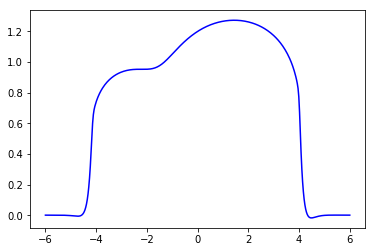

In [28]:
### Setting :
# Call for the information of the example.
Dom, f, g, u_naut, cmax0, qmax0, t_init, t_final, bdy_ext = Problem3()

# Scheme: 1, 2 or 3.
k = 3

# CFL number from 0.5 to 2 is used.
CFL = .5

# Beta parameter for stability (depends on k)
beta = .4

# Number of grid points
N = 400


### Algorithm :
# Set dx
dx = (Dom[1]-Dom[0])/N

# Generate the grid points with the ends included
x = np.linspace(Dom[0], Dom[1], N+1, endpoint=True)

start_time = time.time()

# Set the IC
u = u_naut(x)
cmax = cmax0(u)
qmax = qmax0(u)

# Intialize t
t = t_init

# Stepping routine
while t < t_final:
    dt = set_dt(t,t_final,CFL,dx,cmax,qmax)

    if (k==1):
        rhs1 = MOLT_1x(x,f(u),u,bdy_ext,dx,dt,CFL,cmax,beta)
        rhs2 = MOLT_1xx(x,g(u),bdy_ext,dx,dt,CFL,qmax,beta)
        u = RK1(u, dt, rhs1+rhs2)
        
    elif (k==2):
        u0 = u
        for io in range(0,k):
            rhs1 = MOLT_2x(x,f(u),u,bdy_ext,dx,dt,CFL,cmax,beta)
            rhs2 = MOLT_2xx(x,g(u),bdy_ext,dx,dt,CFL,qmax,beta)
            u = RK2(io, u0, u, dt, rhs1+rhs2)

    elif (k==3):
        u0 = u
        for io in range(0,k):
            rhs1 = MOLT_3x(x,f(u),u,bdy_ext,dx,dt,CFL,cmax,beta)
            rhs2 = MOLT_3xx(x,g(u),bdy_ext,dx,dt,CFL,qmax,beta)
            u = RK3(io, u0, u, dt, rhs1+rhs2)
            
    t += dt    
    
end_time = time.time()
print( 'Total time (s):',end_time - start_time )

plt.plot(x,u,'b')   
plt.show()


### Example 5

We now consider a strongly degenerate parabolic convection-diffusion equation

\begin{align}
u_{t}+f(u)_x=\epsilon(\nu(u)u_x)_x
\end{align}

with $\epsilon=0.1$, $f(u)=u^2$, and

\begin{align}
\nu(u)=\left\{\begin{array}{ll}
0, & |u|\leq 0.25,\\
1, & |u|>0.25 .\\
\end{array}
\right.
\end{align}

We solve the problem with an initial function:

\begin{align}
u(x,0)=\left\{\begin{array}{ll}
1, & -\frac{1}{\sqrt{2}}-0.4<x<-\frac{1}{\sqrt{2}}+0.4,\\
-1,& \frac{1}{\sqrt{2}}-0.4<x<\frac{1}{\sqrt{2}}+0.4,\\
0, & \text{otherwise},\\
\end{array}
\right.
\end{align}

and a zero boundary condition $u(\pm 2,t)=0$ until final time $T=0.7$.

In [18]:
def Problem5():
    '''
    Example5. The Porous Medium Equation
    u_t + f(u)_x = eps * ( v(u) * u_x )_x
    '''
    Dom = [-2, 2]
    
    c = 1
    eps = 0.1
    
    def f(u):
        fu = u**2
        return fu
    
    def g(u):
        gu = np.zeros_like(u)
        
        for i in range(u.shape[0]):
            if ( 0.25 < u[i] ):
                gu[i] = eps * ( u[i] - 0.25 )
            elif ( u[i] < -0.25 ):
                gu[i] = eps * ( u[i] + 0.25 )
            else:
                gu[i] = 0
                
        return gu
    
    def u_naut(x):
        u = np.zeros_like(x)
        
        for i in range(x.shape[0]):
            if (-1/np.sqrt(2) - 0.4 < x[i] < -1/np.sqrt(2) + 0.4 ):
                u[i] = 1
            elif (1/np.sqrt(2) - 0.4 < x[i] < 1/np.sqrt(2) + 0.4 ):
                u[i] = -1
            else:
                u[i] = 0

        return u
    
    # Compute maximum speed for the IC
    def cmax0(u):
        cmax = max( np.abs(2*u) )
        return cmax
        
    # Compute maximum speed for the IC
    def qmax0(u):
        qmax = eps
        return qmax
    
    # Time interval
    t_init = 0
    t_final = 0.7

    # Boundary Extension
    def bdy_ext(v, bn):
        bdy_ext=bdy_zero(v, bn)
        return bdy_ext
    
    # Zero Boundary Extension
    def bdy_zero(v, bn):
        len_v = v.shape[0]
        v2 = np.zeros(len_v + 2*bn)
        v2[bn:len_v+bn] = v
        
        return v2
    
        
    return Dom, f, g, u_naut, cmax0, qmax0, t_init, t_final, bdy_ext

### Main : 1D

Total time (s): 1.1638624668121338


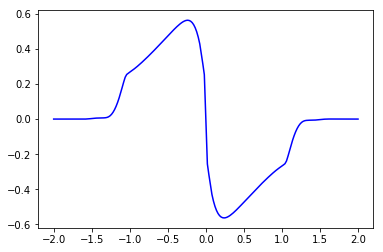

In [29]:
### Setting :
# Call for the information of the example.
Dom, f, g, u_naut, cmax0, qmax0, t_init, t_final, bdy_ext = Problem5()

# Scheme: 1, 2 or 3
k = 3

# CFL number from 0.5 to 2 is used.
CFL = .5

# Beta parameter for stability (depends on k)
beta = .4

# Number of grid points
N = 200


### Algorithm :
# Set dx
dx = (Dom[1]-Dom[0])/N

# Generate the grid points with the ends included
x = np.linspace(Dom[0], Dom[1], N+1, endpoint=True)

start_time = time.time()

# Set the IC
u = u_naut(x)
cmax = cmax0(u)
qmax = qmax0(u)

# Intialize t
t = t_init

# Stepping routine
while t < t_final:
    dt = set_dt(t,t_final,CFL,dx,cmax,qmax)

    if (k==1):
        rhs1 = MOLT_1x(x,f(u),u,bdy_ext,dx,dt,CFL,cmax,beta)
        rhs2 = MOLT_1xx(x,g(u),bdy_ext,dx,dt,CFL,qmax,beta)
        u = RK1(u, dt, rhs1+rhs2)
        
    elif (k==2):
        u0 = u
        for io in range(0,k):
            rhs1 = MOLT_2x(x,f(u),u,bdy_ext,dx,dt,CFL,cmax,beta)
            rhs2 = MOLT_2xx(x,g(u),bdy_ext,dx,dt,CFL,qmax,beta)
            u = RK2(io, u0, u, dt, rhs1+rhs2)

    elif (k==3):
        u0 = u
        for io in range(0,k):
            rhs1 = MOLT_3x(x,f(u),u,bdy_ext,dx,dt,CFL,cmax,beta)
            rhs2 = MOLT_3xx(x,g(u),bdy_ext,dx,dt,CFL,qmax,beta)
            u = RK3(io, u0, u, dt, rhs1+rhs2)
            
    t += dt    
    
end_time = time.time()
print( 'Total time (s):',end_time - start_time )

plt.plot(x,u,'b')  
plt.show()

## 6. Two-dimensional implementation

Consider the following two-dimensional problem

\begin{equation}
\label{eq:2d}
u_{t}+f_{1}(u)_{x}+f_2(u)_{y}=g_{1}(u)_{xx}+g_2(u)_{yy}.
\end{equation}

The proposed one-dimensional formulation can be directly extended to solving this based on a dimension-by-dimension approach. More specifically, for periodic boundary conditions

\begin{align*}
g_{1}(u)_{xx}|_{(x_{i},y_{j})} & \approx -\alpha^2_{0,x}\sum_{p=1}^{k}\mathcal{D}_{0}^{p} [g_1(\cdot,y_{j}),\alpha_{0,x}](x_{i}),\\
g_{2}(u)_{yy}|_{(x_{i},y_{j})} & \approx -\alpha^2_{0,y}\sum_{p=1}^{k}\mathcal{D}_{0}^{p} [g_2(x_{i},\cdot),\alpha_{0,y}](y_{j}),
\end{align*}

where $\alpha_{0,*}=\sqrt{q_*/(\beta\Delta t)}$ with $*=x, y$ and
$q_{x}=\max_{u}|g'_1(u)|$, $q_{y}=\max_{u}|g'_2(u)|$.

To approximate $f_{1}(u)_{x}$ and $f_{2}(u)_y$, the flux splitting strategy is still needed:

\begin{align*}
& f_{1}^{\pm}(u)=\frac{1}{2}(f_{1}(u)\pm c_{x}u), \quad
 f_{2}^{\pm}(u)=\frac{1}{2}(f_{2}(u)\pm c_{y}u), 
\end{align*}

where $c_{x}=\max_{u}|f'_{1}(u)|$ and  $c_{y}=\max_{u}|f'_{2}(u)|$.
Then, the dimension-by-dimension approach can be similarly applied. Again, for periodic boundary conditions, 

\begin{align*}
& f_{1}(u)_{x}|_{(x_{i},y_{j})}\approx -\alpha_{L,x}\sum_{p=1}^{k}\mathcal{D}_{L}^{p} [f_1^{+}(\cdot,y_{j}),\alpha_{L,x}](x_{i}) + \alpha_{R,x}\sum_{p=1}^{k}\mathcal{D}_{R}^{p} [f_1^{-}(\cdot,y_{j}),\alpha_{R,x}](x_{i}),\\
& f_{2}(u)_{y}|_{(x_{i},y_{j})}\approx -\alpha_{L,y}\sum_{p=1}^{k}\mathcal{D}_{L}^{p} [f^{+}_2(x_{i},\cdot),\alpha_{L,y}](y_{j}) + \alpha_{R,y}\sum_{p=1}^{k}\mathcal{D}_{R}^{p} [f^{-}_2(x_{i},\cdot),\alpha_{R,y}](y_{j}),
\end{align*}

or with a modified term for $k=3$. We choose $\alpha_{L,x}=\alpha_{R,x}=\beta/(c_{x}\Delta t)$ and $\alpha_{L,y}=\alpha_{R,y}=\beta/(c_y\Delta t )$.

In the two-dimensional case,  $\beta_{\max}$ needs to be chosen as half of that for one-dimensional problems to attain the unconditional stability for the scheme. 


## Numerical Results: 2D

### Setting the time step

In 2-D, we select the time step at each interation using

\begin{align*}
\Delta t=\frac{\text{CFL}}{ (q_{x}+c_{x})/\Delta x  +  (q_{y}+c_{y})/\Delta y }.
\end{align*}

In [20]:
def set_dt2d(t,t_final,CFL,dx,cmax,qmax):
    '''
    This is the function used to compute the time step size dt.
    In this notebook, dx = dy, c_x = c_y and q_x = q_y.
    
    Input:
    =================================================================
    t: Current time for the integrator.
    t_final: Final time for the integrator.
    CFL: Courant number. 
    dx: Spatial step size.
    cmax: Max wave propogation speed depend on f(u).
    qmax: Max wave propogation speed depend on g(u).
    
    Output:
    =================================================================
    dt: Time step size for the next iteration. 
    '''
    dt = CFL * dx / ( cmax + qmax ) / 2
    
    # End case for the integrator
    if (t + dt > t_final - 1e-10):
        dt = t_final - t
        
    return dt

### Example

For the two-dimensional linear advection-diffusion problem

\begin{align}
u_{t}+u_{x}+u_{y}=u_{xx}+u_{yy}
\end{align}

with the periodic boundary conditions, we here test with two initial functions, smooth one:

\begin{align*}
u(x,y,0)=\sin \left(  \frac{x+y}{2} \pi \right)
\end{align*}

and non-smooth one:

\begin{align*}
u(x,y,0)=\left\{\begin{array}{ll}
1, & |x,y|<0.5,\\
0, & \text{otherwise}.\\
\end{array}
\right.
\end{align*}


In [21]:
def Problem2D_1():
    '''
    Example. 2D adv-diffusion equation for smooth initial condition
    u_t + f_1(u)_x + f_2(u)_y = epsilon ( u_{xx} + u_{yy} )
    '''
    DomX = [-2, 2]
    DomY = [-2, 2]
    
    c = 1
    q = 0.01
    
    def f1(u):
        fu = c*u
        return fu
    
    def f2(u):
        fu = c*u
        return fu
    
    def g1(u):
        gu = q*u
        return gu

    def g2(u):
        gu = q*u
        return gu
    
    def u_naut(x, y):
        u = np.zeros((x.shape[0],y.shape[0]))

        for i in range(x.shape[0]):
            for j in range(y.shape[0]):
                u[i][j] = np.sin( 0.5*np.pi*( x[i] + y[j] ) )

        return u
    
    # Compute maximum speed for the IC
    def cmax0(u):
        cmax = max(1e-10, c)
        return cmax
        
    def qmax0(u):
        qmax = max(1e-10, q)
        return qmax
    
    # Time interval
    t_init = 0
    t_final = 1

    # Boundary Extension
    def bdy_ext(v, bn):
        bdy_ext=bdy_per(v, bn)
        return bdy_ext
    
    # Periodic Boundary Extension
    def bdy_per(v, bn):
        len_v = v.shape[0]
        v2 = np.zeros(len_v + 2*bn)
        
        v2[0:bn] = v[-bn-1:-1]
        v2[bn:len_v+bn] = v
        v2[len_v+bn:len_v+2*bn] = v[1:bn+1]
        
        return v2
        
    return DomX, DomY, f1, f2, g1, g2, u_naut, cmax0, qmax0, t_init, t_final, bdy_ext

In [22]:
def Problem2D_2():
    '''
    Example. 2D adv-diffusion equation with box initial condition
    u_t + f_1(u)_x + f_2(u)_y = epsilon ( u_{xx} + u_{yy} )
    '''
    DomX = [-1, 1]
    DomY = [-1, 1]
    
    c = 1
    q = 0.01
    
    def f1(u):
        fu = c*u
        return fu
    
    def f2(u):
        fu = c*u
        return fu
    
    def g1(u):
        gu = q*u
        return gu

    def g2(u):
        gu = q*u
        return gu
    
    def u_naut(x, y):
        u = np.zeros((x.shape[0],y.shape[0]))

        for i in range(x.shape[0]):
            for j in range(y.shape[0]):
                if ( -.5 < x[i] < .5  and  -.5 < y[j] < .5 ):
                    u[i][j] = 1
                else:
                    u[i][j] = 0

        return u
    
    # Compute maximum speed for the IC
    def cmax0(u):
        cmax = max(1e-10, c)
        return cmax
        
    def qmax0(u):
        qmax = max(1e-10, q)
        return qmax
    
    # Time interval
    t_init = 0
    t_final = 2

    # Boundary Extension
    def bdy_ext(v, bn):
        bdy_ext=bdy_per(v, bn)
        return bdy_ext
    
    # Periodic Boundary Extension
    def bdy_per(v, bn):
        len_v = v.shape[0]
        v2 = np.zeros(len_v + 2*bn)
        
        v2[0:bn] = v[-bn-1:-1]
        v2[bn:len_v+bn] = v
        v2[len_v+bn:len_v+2*bn] = v[1:bn+1]
        
        return v2
        
    return DomX, DomY, f1, f2, g1, g2, u_naut, cmax, qmax, t_init, t_final, bdy_ext

### Example 6

We consider the two-dimensional strongly degenerate parabolic convection-diffusion equation

\begin{align}
u_{t}+f(u)_x+f(u)_y=\epsilon(\nu(u)u_x)_x+\epsilon(\nu(u)u_y)_y,
\end{align}

in which, $\epsilon$, $f(u)$, $\nu(u)$ are the same as the one-dimensional case in Example 5. The initial function is given as

\begin{align}
u(x,y,0)=\left\{\begin{array}{ll}
1, & (x+0.5)^2+(y+0.5)^2<0.16,\\
-1,& (x-0.5)^2+(y-0.5)^2<0.16,\\
0, & \text{otherwise}.\\
\end{array}
\right.
\end{align}

The solutions at $T=0.5$ are computed by the third order scheme with $\beta=0.2$, $CFL=0.5$ and $200\times200$ grid points.

In [23]:
def Problem6():
    '''
    Example6. a strongly degenerate parabolic convection-diffusion
    u_t + f(u)_x + g(u)_y = eps * ( v(u) * u_x )_x + eps * ( v(u) * u_y )_y
    '''
    DomX = [-1.5, 1.5]
    DomY = [-1.5, 1.5]
    
    c = 1
    eps = 0.1
    
    def f1(u):
        fu = u**2
        return fu
    
    def f2(u):
        fu = u**2
        return fu
    
    def g1(u):
        gu = np.zeros_like(u)
        
        for i in range(u.shape[0]):
            if ( 0.25 < u[i] ):
                gu[i] = eps * ( u[i] - 0.25 )
            elif ( u[i] < -0.25 ):
                gu[i] = eps * ( u[i] + 0.25 )
            else:
                gu[i] = 0
                
        return gu
    
    def g2(u):
        gu = np.zeros_like(u)
        
        for i in range(u.shape[0]):
            if ( 0.25 < u[i] ):
                gu[i] = eps * ( u[i] - 0.25 )
            elif ( u[i] < -0.25 ):
                gu[i] = eps * ( u[i] + 0.25 )
            else:
                gu[i] = 0
                
        return gu
    
    def u_naut(x, y):
        u = np.zeros((x.shape[0],y.shape[0]))

        for i in range(x.shape[0]):
            for j in range(y.shape[0]):
                r1 = (x[i]+0.5)**2 + (y[j]+0.5)**2
                r2 = (x[i]-0.5)**2 + (y[j]-0.5)**2
                if ( r1 < 0.16 ):
                    u[i][j] = 1
                elif ( r2< 0.16 ):
                    u[i][j] = -1
                else:
                    u[i][j] = 0

        return u

    
    # Compute maximum speed for the IC
    def cmax0(u):
        cmax = np.max( np.abs(2*u) )
        return cmax
        
    def qmax0(u):
        qmax = eps
        return qmax
    
    # Time interval
    t_init = 0
    t_final = 0.5

    # Boundary Extension
    def bdy_ext(v, bn):
        bdy_ext=bdy_zero(v, bn)
        return bdy_ext
    
    # Zero Boundary Extension
    def bdy_zero(v, bn):
        len_v = v.shape[0]
        v2 = np.zeros(len_v + 2*bn)
        v2[bn:len_v+bn] = v
        
        return v2
        
    return DomX, DomY, f1, f2, g1, g2, u_naut, cmax0, qmax0, t_init, t_final, bdy_ext

### Main : 2D

Total time (s): 199.71794271469116


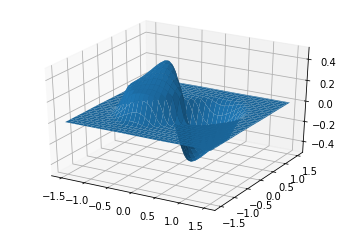

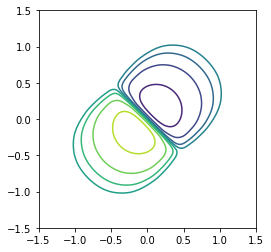

In [30]:
### Setting :
# Call for the information of the example.
DomX, DomY, f1, f2, g1, g2, u_naut, cmax0, qmax0, t_init, t_final, bdy_ext = Problem6()

# Scheme: 1, 2 or 3
k = 3
MOLT_x  = MOLT_3x
MOLT_xx = MOLT_3xx

# CFL number from 0.5 to 2 is used.
CFL = .5

# Beta parameter for stability (depends on k)
beta = .2

# Number of grid points
Nx = 100
Ny = 100


## Algorithm :
# Set dx
dx = (DomX[1]-DomX[0])/Nx
dy = (DomY[1]-DomY[0])/Ny

# Generate the grid points with the ends included
x = np.linspace(DomX[0], DomX[1], Nx+1, endpoint=True)
y = np.linspace(DomY[0], DomY[1], Ny+1, endpoint=True)
X, Y = meshgrid(x, y)

start_time = time.time()

# Set the IC
U = u_naut(x,y)
cmax = cmax0(U)
qmax = qmax0(U)

# Intialize t
t = t_init

# Stepping routine
while t < t_final:
    dt = set_dt2d(t,t_final,CFL,dx,cmax,qmax)
    
    U0 = U
    for io in range(0,k):
        rhs = np.zeros_like(U)
        for j in range(Ny+1):
            
            u = U[:, j]
            rhs1 = MOLT_x(x,f1(u),u,bdy_ext,dx,dt,CFL,cmax,beta)
            rhs2 = MOLT_xx(x,g1(u),bdy_ext,dx,dt,CFL,qmax,beta)
            rhs[:, j] += (rhs1 + rhs2).transpose()
            
            u = U[j, :]
            rhs1 = MOLT_x(x,f2(u),u,bdy_ext,dx,dt,CFL,cmax,beta)
            rhs2 = MOLT_xx(x,g2(u),bdy_ext,dx,dt,CFL,qmax,beta)
            rhs[j, :] += rhs1 + rhs2
                
        U = RK3(io, U0, U, dt, rhs)
    t += dt    

end_time = time.time()
print( 'Total time (s):',end_time - start_time )

# Plot the results
ax=plt.axes(projection='3d')
ax.plot_surface(X,Y,U)
plt.show()

plt.contour(X,Y,U,np.linspace(-0.5, 0.5, 10))
plt.axis('scaled')
plt.show()


### Example 7

As the last example, we solve the two-dimensional Buckley-Leverett Equation

\begin{align}
u_{t}+f_{1}(u)_{x}+f_{2}(u)_{y}=\epsilon(u_{xx}+u_{yy}),
\end{align}

where $\epsilon=0.01$ and the flux functions are given as

$$f_{1}(u)=\frac{u^2}{u^2+(1-u)^2}, \ \ \ f_{2}(u)=(1-5(1-u)^2)f_{1}(u).$$

We compute the problem on $[-1.5,1.5]\times[-1.5,1.5]$, with the initial condition

\begin{align*}
u(x,y,0)=\left\{\begin{array}{ll}
1, & x^2+y^2<0.5,\\
0, & \text{otherwise}.\\
\end{array}
\right.
\end{align*}

In [25]:
def Problem7():
    '''
    Example5. 2D Buckley-Leverett Equation
    u_t + f_1(u)_x + f_2(u)_y = epsilon ( u_{xx} + u_{yy} )
    '''
    DomX = [-1.5, 1.5]
    DomY = [-1.5, 1.5]
    
    c = 1
    eps = 0.01
    
    def f1(u):
        fu = u**2 / ( u**2 + (1-u)**2 )
        return fu
    
    def f2(u):
        fu = ( 1 - 5*(1-u)**2 )*f1(u)
        return fu
    
    def g1(u):
        gu = eps*u
        return gu
    
    def g2(u):
        gu = eps*u
        return gu
    
    def u_naut(x, y):
        u = np.zeros((x.shape[0],y.shape[0]))

        for i in range(x.shape[0]):
            for j in range(y.shape[0]):
                r = x[i]**2 + y[j]**2
                if ( r < 0.5 ):
                    u[i][j] = 1
                else:
                    u[i][j] = 0

        return u
    
    # Compute maximum speed for the IC
    def cmax0(u):
        cmax = 3.3105 #np.max( np.abs(f1'(u)), np.abs(f2'(u)) )
        return cmax
    
    def qmax0(u):
        qmax = eps
        return qmax
    
    # Time interval
    t_init = 0
    t_final = 0.5

    # Boundary Extension
    def bdy_ext(v, bn):
        bdy_ext=bdy_zero(v, bn)
        return bdy_ext
    
    # Zero Boundary Extension
    def bdy_zero(v, bn):
        len_v = v.shape[0]
        v2 = np.zeros(len_v + 2*bn)
        v2[bn:len_v+bn] = v
        
        return v2
    
        
    return DomX, DomY, f1, f2, g1, g2, u_naut, cmax0, qmax0, t_init, t_final, bdy_ext

### Main : 2D

Total time (s): 283.6634440422058


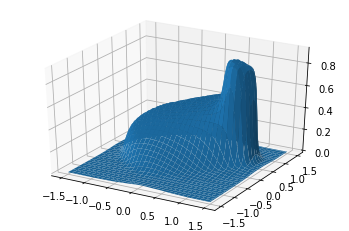

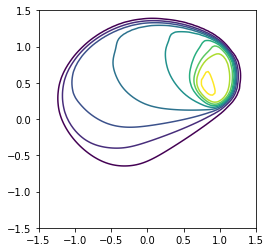

In [31]:
### Setting :
# Call for the information of the example.
DomX, DomY, f1, f2, g1, g2, u_naut, cmax0, qmax0, t_init, t_final, bdy_ext = Problem7()

# Scheme: 1, 2 or 3
k = 3
MOLT_x  = MOLT_3x
MOLT_xx = MOLT_3xx

# CFL number from 0.5 to 2 is used.
CFL = .5

# Beta parameter for stability (depends on k)
beta = .2

# Number of grid points
Nx = 100
Ny = 100


### Algorithm :
# Set dx
dx = (DomX[1]-DomX[0])/Nx
dy = (DomY[1]-DomY[0])/Ny

# Generate the grid points with the ends included
x = np.linspace(DomX[0], DomX[1], Nx+1, endpoint=True)
y = np.linspace(DomY[0], DomY[1], Ny+1, endpoint=True)
X, Y = meshgrid(x, y)

start_time = time.time()

# Set the IC
U = u_naut(x,y)
cmax = cmax0(U)
qmax = qmax0(U)

# Intialize t
t = t_init

# Stepping routine
while t < t_final:
    dt = set_dt2d(t,t_final,CFL,dx,cmax,qmax)
    
    U0 = U
    for io in range(0,k):
        rhs = np.zeros_like(U)
        for j in range(Ny+1):
            
            u = U[:, j]
            rhs1 = MOLT_x(x,f1(u),u,bdy_ext,dx,dt,CFL,cmax,beta)
            rhs2 = MOLT_xx(x,g1(u),bdy_ext,dx,dt,CFL,qmax,beta)
            rhs[:, j] += (rhs1 + rhs2).transpose()
            
            u = U[j, :]
            rhs1 = MOLT_x(x,f2(u),u,bdy_ext,dx,dt,CFL,cmax,beta)
            rhs2 = MOLT_xx(x,g2(u),bdy_ext,dx,dt,CFL,qmax,beta)
            rhs[j, :] += rhs1 + rhs2
                
        U = RK3(io, U0, U, dt, rhs)
    t += dt    


end_time = time.time()
print( 'Total time (s):',end_time - start_time )

# Plot the results
ax=plt.axes(projection='3d')
ax.plot_surface(X,Y,U)
plt.show()

# plt.contour(X,Y,U,np.linspace(0.1, 0.9, 15))
plt.contour(X,Y,U,[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
plt.axis('scaled')
plt.show()